# 파충강(거북목, 뱀목, 악어목) COI 염기서열 추출 후 군집화(Alignment 과정 x + 비지도학습)

## 데이터 수집 자동 크롤러를 위한 함수들(getOrganism() -> getGenbank())

In [1]:
#[220505_1137]UPDATED 지금까지 구성을 전부 정리함
from Bio import Entrez, SeqIO, AlignIO
from Bio.Align.Applications import MuscleCommandline
from pathlib import Path
from Bio import GenBank
from Bio.SeqUtils import GC

Entrez.email = "nagabuti13@naver.com"

#[220502_1717]CREATED getIdList: NCBI에서 keyword를 검색하여 script의 id를 추출한다
#[220512_1210]NOTED esearch()의 파라미터에 id의 개수를 조절하는 retmax 파라미터가 존재
def getIdlist(database, keyword):
    handle = Entrez.esearch(db = database, retmax = 10000, term = keyword)
    records = Entrez.read(handle)
    return records["IdList"]

#[220505_1717]CREATED getFastaFile: NCBI에서 id를 검색하여 얻은 fasta파일을 컴퓨터에 저장한다
def getFasta(id):
    handle = Entrez.efetch(db = 'nucleotide', id = id, rettype = 'fasta', retmode = 'text')
    record = SeqIO.read(handle, 'fasta')
    print('## creating ' + record.id + '.fasta...')
    with open(record.id + '.fasta', 'w') as f:
        f.write('>' + record.description + '\n')
        f.write(str(record.seq) + '\n')
    
#[220502_1717]CREATED getAlnFile: 다중염기서열을 생성하는 툴 중 하나인 MUSCLE로 aln파일을 생성한다
def getAln(filename):
    muscle_exe = '/Users/kimjoonsu/muscle3.8.31_i86darwin64'
    cmd_line = MuscleCommandline(muscle_exe, input = filename,
                             out = Path(filename).stem + '.aln', clw = ' ')
    print(cmd_line)
    stdout, stderr = cmd_line()   
    
#[220509_1517]CREATED ncbi에서 alignment의 각 record genbank파일로부터 종 이름을 반환
def getGenbank(id):
    handle = Entrez.efetch(db = "nucleotide", rettype = "gb", id = id, retmode = "text")
    r = GenBank.read(handle)
    #[220811_1431]NOTED getOrganism() -> getGenbank()
    return r

In [2]:
#[220505_2320]CREATED 차레대로 토끼, 쥐, 다람쥐의 COI 염기서열 종 목록
#[220520_0628]CREATED 종 9개로 제한
#[220811_1321]CREATED 9개의 종을 쿼리로 날리고 부정확한 검색 결과를 제거하기 위해 CO1 여부와 종 명칭 일치 여부를 확인하여 정확한 FASTA파일만을 수집하도록 함 -> 기존 144개보다 3배 많은 418개 데이터 확보
#[220818_1643]CREATED 파충강의 거북, 뱀, 악어목에 속하는 9종 선정
species = ['Trachemys scripta elegans', 'Pelodiscus sinensis', 'Caretta caretta', 
           'Ophiophagus hannah', 'Gekko gecko', 'Varanus indicus', 
           'Alligator sinensis', 'Gavialis gangeticus', 'Crocodylus porosus']
count = 0

for s in species:
    Idlist = getIdlist('nucleotide', 'coi ' + s)
    Idlist = [id for id in Idlist if getGenbank(id).organism in s and 'COI' in getGenbank(id).definition]
    for id in Idlist:
        getFasta(id)
        count += 1
print(count)

## creating MH274719.1.fasta...
## creating MW774636.1.fasta...
## creating MW774635.1.fasta...
## creating MW774634.1.fasta...
## creating MW774633.1.fasta...
## creating MW774632.1.fasta...
## creating MW774631.1.fasta...
## creating MW774630.1.fasta...
## creating MW774629.1.fasta...
## creating MW774628.1.fasta...
## creating MW774627.1.fasta...
## creating MW774626.1.fasta...
## creating MW774625.1.fasta...
## creating MW774624.1.fasta...
## creating MW774623.1.fasta...
## creating MW774622.1.fasta...
## creating KX559045.1.fasta...
## creating KX559044.1.fasta...
## creating MZ046118.1.fasta...
## creating MZ046117.1.fasta...
## creating MZ046116.1.fasta...
## creating MZ046115.1.fasta...
## creating MZ046114.1.fasta...
## creating MZ046113.1.fasta...
## creating MZ046112.1.fasta...
## creating MZ046111.1.fasta...
## creating MZ046110.1.fasta...
## creating MZ046109.1.fasta...
## creating MZ046108.1.fasta...
## creating MZ046107.1.fasta...
## creating MZ046106.1.fasta...
## creat

## alignment 대신 GC함량 값으로 시퀀스 슬라이싱

### GC함량 최댓값 범위 확인

In [4]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_reptilia_coi.fasta', 'fasta')

l = []
for record in file:
    l.append(len(record.seq))
k_gc = min(l)
print(np.std(l))
print(k_gc)
#[220805_1705]NOTED 길이가 가장 짧은 시퀀스의 bp를 k-mers의 k로 설정

gc_df = pd.DataFrame()
gc_df['start index'] = 0
gc_df['gc-contents'] = 0

file = SeqIO.parse('all_reptilia_coi.fasta', 'fasta')

for i, record in enumerate(file):
    index = 0
    gc_rates = []
    while(index + 4 <= len(record.seq)):
        mer = record.seq[index:index + 4]
        gc_rates.append(GC(mer))
        index += 1
    gc_df.loc[i, 'start index'] = gc_rates.index(max(gc_rates))
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 시작 인덱스를 저장
    gc_df.loc[i, 'gc-contents'] = max(gc_rates)
    #[220805_1706]NOTED GC함량이 가장 높은 mer의 GC함량을 저장

264.34295259631915
210


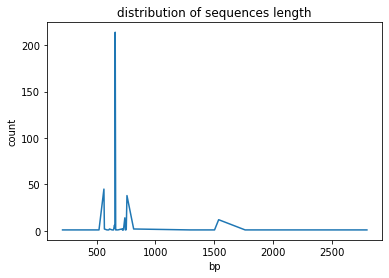

In [3]:
import matplotlib.pyplot as plt

x = sorted(set(l))
y = [l.count(x) for x in x]
plt.plot(x, y)
plt.title('distribution of sequences length')
plt.xlabel('bp')
plt.ylabel('count')
plt.show()
plt.close()

In [3]:
""" # row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)
 """
gc_df

,start index,gc-contents
0,63.0,100.0
1,69.0,100.0
2,66.0,100.0
3,40.0,100.0
4,49.0,100.0
...,...,...
368,59.0,100.0
369,59.0,100.0
370,59.0,100.0
371,59.0,100.0


### 기존 데이터 슬라이싱 후 3-mer 적용

In [4]:
import pandas as pd
import numpy as np

file = SeqIO.parse('all_reptilia_coi.fasta', 'fasta')

k = 3
dict = {}
df = pd.DataFrame()

#[220513_1700]CREATED AGCT 외의 염기를 처리하기 위해 사전형에 key, value로 저장 
base_dict = {'A':'A', 'G':'G', 'C':'C', 'T':'T', 'U':'U',
'Y':'T', 'R':'A', 'S':'C', 'W':'A', 'K':'G', 'M':'C', 'B':'C', 'D':'G', 'H':'T', 'V':'C', 'N':'A'}

#[220508_1735]CREATED k = 3인 kmer의 모든 경우의 수를 사전형에 미리 저장
def init(datatype):
    for i in range(4):
        for j in range(4):
            for k in range(4):
                datatype[list(base_dict.keys())[i] + list(base_dict.keys())[j] + list(base_dict.keys())[k]] = 0
    #[220509_1517]CREATED k-means는 unsupervised이지만, 여기서는 표본의 타겟을 ncbi에서부터 추출가능하므로 타겟 피처 생성
    datatype['GC-contents'] = 0
    datatype['target'] = 0
    
init(df)

for i, record in enumerate(file):
    init(dict)
    record.seq = record.seq[int(gc_df.loc[i, 'start index']): int(gc_df.loc[i, 'start index']) + k_gc]
    #[220805_1023]CREATED 최대 GC 값 범위로 기존 데이터 슬라이싱
    dict['GC-contents'] = gc_df.loc[i, 'gc-contents']
    #[220805_1025]CREATED 최대 GC 값 저장
    dict['target'] = getGenbank(record.id).organism
    
    index = 0
    
    if(len(record.seq) >= k):
        while(index + k <= len(record.seq)):
            mer = record.seq[index:index + k]
            for p in range(k):
                mer = mer.replace(mer[p], base_dict.get(mer[p]))
            dict[mer] += 1
            index += 1
    df.loc[i] = dict

In [5]:
df.groupby('target').count()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents
target,,,,,,,,,,,,,,,,,,,,,
Alligator sinensis,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
Caretta caretta,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
Crocodylus porosus,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21
Gavialis gangeticus,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Gekko gecko,228,228,228,228,228,228,228,228,228,228,...,228,228,228,228,228,228,228,228,228,228
Ophiophagus hannah,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
Pelodiscus sinensis,42,42,42,42,42,42,42,42,42,42,...,42,42,42,42,42,42,42,42,42,42
Trachemys scripta elegans,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
Varanus indicus,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7


In [9]:
#[220811_1437]NOTED 9종으로 잘 크롤링되었음을 확인
df['target'].unique()

array(['Ophiophagus hannah', 'Gekko gecko', 'Varanus indicus',
       'Crocodylus porosus', 'Caretta caretta', 'Gavialis gangeticus',
       'Pelodiscus sinensis', 'Trachemys scripta elegans',
       'Alligator sinensis'], dtype=object)

In [10]:
""" # row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)
 """
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,1,1,4,4,2,0,6,2,1,2,...,4,2,2,2,6,3,3,9,100.0,Ophiophagus hannah
1,1,1,4,4,2,0,6,2,1,2,...,4,2,2,2,6,3,3,9,100.0,Ophiophagus hannah
2,1,1,4,4,2,0,6,2,1,2,...,4,2,2,2,6,3,3,9,100.0,Ophiophagus hannah
3,8,2,5,7,3,3,1,2,2,1,...,4,2,4,3,5,2,1,4,100.0,Gekko gecko
4,6,4,3,8,2,3,4,2,4,2,...,5,1,7,2,7,2,5,0,100.0,Varanus indicus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,1,1,7,8,0,1,4,2,5,3,...,3,2,3,2,4,5,5,5,100.0,Gekko gecko
369,2,1,6,9,0,1,4,2,4,2,...,2,1,5,2,5,6,3,4,100.0,Gekko gecko
370,2,2,6,9,0,1,5,1,5,3,...,2,1,5,1,3,6,3,6,100.0,Gekko gecko
371,2,1,6,9,0,1,4,2,4,2,...,2,1,5,2,5,6,3,4,100.0,Gekko gecko


In [11]:
#[220509_1621]CREATED 레이블 인코딩으로 종 이름 -> 고유 숫자
from sklearn.preprocessing import LabelEncoder

a = df['target']
encoder = LabelEncoder()
labels = encoder.fit_transform(a)
#[220509_1622]NOTED* 종의 총 개수 = 19인 것을 알 수 있으므로 KMeans의 파라미터인 n_clusters를 14 -> 19로 수정
#[220513_1830]NOTED 종: 101개
#[220519_1745]NOTED 종: 9개
print(labels)

df['target'] = labels
df.head()

[5 5 5 4 8 8 8 2 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 6 6 6 6 6 6 5 1 1 5
 1 1 1 1 1 1 1 7 7 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 3 3 7 8 8 8
 8 4 1 3 3 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4
 4 4 4]


,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,1,1,4,4,2,0,6,2,1,2,...,4,2,2,2,6,3,3,9,100.0,5
1,1,1,4,4,2,0,6,2,1,2,...,4,2,2,2,6,3,3,9,100.0,5
2,1,1,4,4,2,0,6,2,1,2,...,4,2,2,2,6,3,3,9,100.0,5
3,8,2,5,7,3,3,1,2,2,1,...,4,2,4,3,5,2,1,4,100.0,4
4,6,4,3,8,2,3,4,2,4,2,...,5,1,7,2,7,2,5,0,100.0,8


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
#[220805_1714]NOTED* GC함량을 정규화
scaler.fit(df['GC-contents'].array.reshape(-1, 1))
gc_scaled = scaler.transform(df['GC-contents'].array.reshape(-1, 1))
df['GC-contents'] = gc_scaled

In [13]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,1,1,4,4,2,0,6,2,1,2,...,4,2,2,2,6,3,3,9,0.0,5
1,1,1,4,4,2,0,6,2,1,2,...,4,2,2,2,6,3,3,9,0.0,5
2,1,1,4,4,2,0,6,2,1,2,...,4,2,2,2,6,3,3,9,0.0,5
3,8,2,5,7,3,3,1,2,2,1,...,4,2,4,3,5,2,1,4,0.0,4
4,6,4,3,8,2,3,4,2,4,2,...,5,1,7,2,7,2,5,0,0.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,1,1,7,8,0,1,4,2,5,3,...,3,2,3,2,4,5,5,5,0.0,4
369,2,1,6,9,0,1,4,2,4,2,...,2,1,5,2,5,6,3,4,0.0,4
370,2,2,6,9,0,1,5,1,5,3,...,2,1,5,1,3,6,3,6,0.0,4
371,2,1,6,9,0,1,4,2,4,2,...,2,1,5,2,5,6,3,4,0.0,4


## SVM 모델 생성

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'macro')
    recall = recall_score(y_test, pred, average = 'macro')
    
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2:.2f}'.format(accuracy, precision, recall))
    
    
svm_2 = SVC(kernel = 'linear') 
#[220715_1739]NOTED 모델 생성

X = df.loc[:, 'AAA':'GC-contents']
y = df['target']

scaler = StandardScaler()
new_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size = 0.2)
#[220715_1740]NOTED 학습 데이터와 테스트 데이어셋으로 무작위 분리한 뒤 정규화

parameters = {'C':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'gamma':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
#[220715_1741]NOTED 파라미터 후보 설정

grid_svm = GridSearchCV(svm_2, param_grid = parameters, cv = 5)
grid_svm.fit(X_train, y_train)  
#[220711_1658]NOTED 검증 데이터셋 + 학습 데이터셋 = 원래 학습 데이터셋

print(grid_svm.best_params_)
print(grid_svm.best_score_)
best_pred = grid_svm.best_estimator_.predict(X_test)
get_clf_eval(y_test, best_pred)

{'C': 1, 'gamma': 1}
0.99
오차 행렬
[[ 1  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0 51  0  0  0  1]
 [ 0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  2]]
정확도: 0.99, 정밀도: 0.96, 재현율: 1.00


## KMeans 모델의 최적 K값 구하기

### Elbow Method

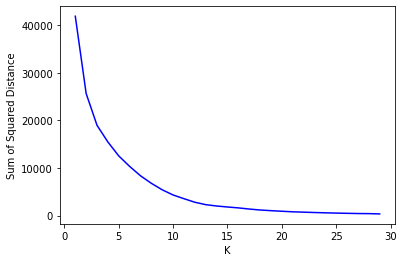

In [9]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

ks = range(1, 30)
sse = []
for k in ks:
    km = KMeans(n_clusters = k, max_iter = 5000)
    km.fit(df.iloc[:,:-1])
    sse.append(km.inertia_)

plt.plot(ks, sse, 'b')
plt.xlabel('K')
plt.ylabel('Sum of Squared Distance')
plt.show()
#[220805_1649]CREATED k = 6일 때가 최적 but 실제는 9

### Silhouette Method

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

ks = range(2, 20)
for k in ks:
    kmeans = KMeans(n_clusters = k, max_iter=5000)
    kmeans.fit(df.iloc[:,:-1])
    df['cluster'] = kmeans.labels_
    df['sil_sam'] = silhouette_samples(df.iloc[:, :-2], df['cluster'])
    #[220805_1651]NOTED silhouette_samples: 점의 실루엣 계수
    sil_tot = silhouette_score(df.iloc[:, :-3], df['cluster'])
    #[220805_1652]NOTED silhouette_score: 전체의 실루엣 계수
    sil_clu = df.groupby('cluster')['sil_sam'].mean()
    score_k = np.mean([abs(i - sil_tot) for i in sil_clu])
    print('전체 실루엣 계수 평균: {0:.3f}\n군집 별 실루엣 계수 평균: \n{1}'.format(sil_tot, sil_clu))
    print('score: {0:.3f}'.format(score_k))
    #[220805_1712]NOTED 전체 실루엣 계수와 군집 별 실루엣 계수 간의 편차의 제곱을 구하여 성능 지표로 활용
    print('---------------')
    df.drop('cluster', axis = 1, inplace = True)
    df.drop('sil_sam', axis = 1, inplace = True)
    #[220811_1518]NOTED k = 10일 때 최적 but 실제는 9

전체 실루엣 계수 평균: 0.558
군집 별 실루엣 계수 평균: 
cluster
0    0.444629
1    1.000000
Name: sil_sam, dtype: float64
score: 0.278
---------------
전체 실루엣 계수 평균: 0.715
군집 별 실루엣 계수 평균: 
cluster
0    0.121262
1    1.000000
2    1.000000
Name: sil_sam, dtype: float64
score: 0.388
---------------
전체 실루엣 계수 평균: 0.796
군집 별 실루엣 계수 평균: 
cluster
0    0.337005
1    1.000000
2    1.000000
3    0.447000
Name: sil_sam, dtype: float64
score: 0.304
---------------
전체 실루엣 계수 평균: 0.865
군집 별 실루엣 계수 평균: 
cluster
0    1.000000
1    0.544140
2    1.000000
3    0.444517
4    1.000000
Name: sil_sam, dtype: float64
score: 0.229
---------------
전체 실루엣 계수 평균: 0.897
군집 별 실루엣 계수 평균: 
cluster
0    0.737945
1    1.000000
2    0.364603
3    1.000000
4    1.000000
5    1.000000
Name: sil_sam, dtype: float64
score: 0.184
---------------
전체 실루엣 계수 평균: 0.926
군집 별 실루엣 계수 평균: 
cluster
0    0.147831
1    1.000000
2    1.000000
3    0.957447
4    1.000000
5    1.000000
6    1.000000
Name: sil_sam, dtype: float64
score: 0.168
--------------

/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_48000/596326150.py:8: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])


전체 실루엣 계수 평균: 0.997
군집 별 실루엣 계수 평균: 
cluster
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    0.0
11    1.0
Name: sil_sam, dtype: float64
score: 0.093
---------------


/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_48000/596326150.py:8: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])
/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_48000/596326150.py:8: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])


전체 실루엣 계수 평균: 0.997
군집 별 실루엣 계수 평균: 
cluster
0     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    0.0
11    1.0
Name: sil_sam, dtype: float64
score: 0.093
---------------
전체 실루엣 계수 평균: 0.997
군집 별 실루엣 계수 평균: 
cluster
0     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    0.0
11    1.0
Name: sil_sam, dtype: float64
score: 0.093
---------------


/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_48000/596326150.py:8: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])


전체 실루엣 계수 평균: 0.997
군집 별 실루엣 계수 평균: 
cluster
0     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    0.0
11    1.0
Name: sil_sam, dtype: float64
score: 0.093
---------------


/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_48000/596326150.py:8: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])
/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_48000/596326150.py:8: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])
/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_48000/596326150.py:8: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])
/var/folders/k8/6ll3wmpx4pb47d31hygxs_j80000gn/T/ipykernel_48000/596326150.py:8: ConvergenceWarning: Number of distinct clusters (11) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  kmeans.fit(df.iloc[:,:-1])


전체 실루엣 계수 평균: 0.997
군집 별 실루엣 계수 평균: 
cluster
0     1.0
1     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    0.0
11    1.0
Name: sil_sam, dtype: float64
score: 0.093
---------------
전체 실루엣 계수 평균: 0.997
군집 별 실루엣 계수 평균: 
cluster
1     1.0
2     1.0
3     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    0.0
11    1.0
16    1.0
Name: sil_sam, dtype: float64
score: 0.093
---------------
전체 실루엣 계수 평균: 0.997
군집 별 실루엣 계수 평균: 
cluster
0     1.0
3     1.0
4     1.0
5     1.0
7     1.0
8     1.0
9     1.0
10    0.0
11    1.0
16    1.0
17    1.0
Name: sil_sam, dtype: float64
score: 0.093
---------------
전체 실루엣 계수 평균: 0.997
군집 별 실루엣 계수 평균: 
cluster
2     1.0
3     1.0
4     1.0
5     1.0
7     1.0
8     1.0
9     1.0
10    0.0
11    1.0
16    1.0
17    1.0
Name: sil_sam, dtype: float64
score: 0.093
---------------


## K-means 모델 생성

In [11]:
def cal_accuracy(target, cluster):
    ct = pd.crosstab(target, cluster)
    accuracy = 0
    for i in range(ct.iloc[:, 0].count()):
        accuracy += ct.iloc[i,:].max() / ct.iloc[i,:].sum()
    return accuracy / ct.iloc[:, 0].count()
#[220812_1340]CREATED 비지도학습에서의 정확도 계산 함수 생성

### 교차 검증

* 검증 데이터셋 생성x(학습 데이터량의 변화에 따른 모델의 정확도 변화 분석에 용이)

In [13]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 1
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_test = data.iloc[start_index:start_index + len(df.index) // cv]
    y_test = label[start_index:start_index + len(df.index) // cv]
    kmeans = KMeans(n_clusters = len(y_test.unique()), max_iter = 1000)
    kmeans.fit(X_test)
    accuracy.append(np.round(cal_accuracy(y_test, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))
#[220813_1117]NOTED 검증 데이터셋이 없고, 학습 데이터셋의 수는 cv값과 반비례하기 때문에, cv값이 증가함에 따라 정확도는 감소
#[220813_1117]NOTED 학습 데이터 수가 줄어듬에 따라 모델의 정확도 변화율을 분석하기에 용이

교차 검증별 정확도: [0.7976]
평균 검증 정확도: 0.7976


* 검증 데이터셋 생성

In [14]:
from sklearn.cluster import KMeans
data = df.iloc[:,:-1]
label = df['target']
#[220812_1141]CREATED 교차 검증을 위한 모델, 데이터, 라벨 생성
cv = 5
#[220812_2338]NOTED 검증 데이터셋 개수
start_index = 0
accuracy = []
for i in range(cv):
    X_train, X_test = pd.concat([data.iloc[0:start_index], data.iloc[start_index + len(df.index) // cv:]]), data.iloc[start_index:start_index + len(df.index) // cv]
    y_train, y_test = pd.concat([label[0:start_index], label[start_index + len(df.index) // cv:]]), label[start_index:start_index + len(df.index) // cv] 
    #[220813_1108]CREATED X_test, y_test: 검증 데이터셋
    kmeans = KMeans(n_clusters = len(y_train.unique()), max_iter = 1000)
    kmeans.fit(X_train)
    accuracy.append(np.round(cal_accuracy(y_train, kmeans.labels_), 4))
    #[220812_2338]CREATED crosstab에 새로운 데이터를 넣을 때는 리스트로 넣기
    #[220813_1108]CREATED predict()를 통해 새로운 데이터셋에 대한 cluster 레이블을 출력하여 정답지인 y_test와 비교한다.
    start_index += (len(df.index) // cv)
print('교차 검증별 정확도:', accuracy)
print('평균 검증 정확도:', np.round(np.mean(accuracy), 4))

교차 검증별 정확도: [0.8684, 0.8213, 0.7847, 0.8098, 0.759]
평균 검증 정확도: 0.8086


## 차원 축소 및 데이터 분포 확인

In [19]:
km = KMeans(n_clusters = 10, max_iter = 1000)
km.fit(df.iloc[:,:-1])
cal_accuracy(df['target'], km.labels_)

0.797604983277498

In [18]:
df.drop('pca_x', axis = 1, inplace = True)
df.drop('pca_y', axis = 1, inplace = True)
df.drop('cluster', axis = 1, inplace = True)

KeyError: "['pca_x'] not found in axis"

In [88]:
df

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,GC-contents,target
0,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,0.545455,5
1,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,0.545455,5
2,1,2,3,2,3,4,7,3,6,0,...,5,1,4,6,3,0,5,6,0.545455,5
3,2,1,5,2,1,4,3,3,3,4,...,2,4,4,3,5,2,3,5,0.939394,4
4,7,1,5,5,1,4,4,1,5,0,...,7,1,7,1,2,2,4,0,0.606061,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,0,2,3,1,1,1,8,1,5,2,...,1,0,5,7,3,0,6,5,0.818182,4
369,1,1,1,3,0,3,5,2,5,1,...,1,1,7,8,1,0,5,3,0.848485,4
370,1,1,2,1,1,3,7,2,4,1,...,1,0,5,9,1,0,5,3,0.848485,4
371,1,1,1,2,0,3,5,2,5,1,...,1,1,7,8,1,0,5,3,0.848485,4


In [100]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca_transformed = pca.fit_transform(df.iloc[:, :-2])

df['pca_x'] = pca_transformed[:, 0]
df['pca_y'] = pca_transformed[:, 1]
df.head()

,AAA,AAG,AAC,AAT,AGA,AGG,AGC,AGT,ACA,ACG,...,TCT,TTA,TTG,TTC,TTT,GC-contents,target,cluster,pca_x,pca_y
0,1,2,3,2,3,4,7,3,6,0,...,6,3,0,5,6,0.545455,5,7,5.707575,0.816405
1,1,2,3,2,3,4,7,3,6,0,...,6,3,0,5,6,0.545455,5,7,5.707575,0.816405
2,1,2,3,2,3,4,7,3,6,0,...,6,3,0,5,6,0.545455,5,7,5.707575,0.816405
3,2,1,5,2,1,4,3,3,3,4,...,3,5,2,3,5,0.939394,4,3,1.473340,-0.440239
4,7,1,5,5,1,4,4,1,5,0,...,1,2,2,4,0,0.606061,8,5,5.324334,2.032612


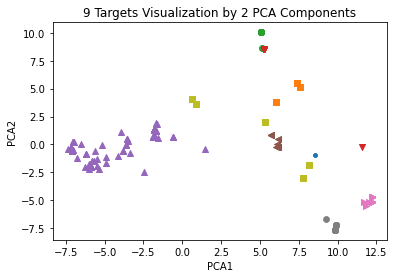

In [101]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['target'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Targets Visualization by 2 PCA Components')
plt.show()

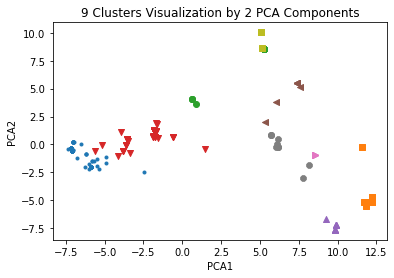

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

marker_ind = []
for i in range(9):
    marker_ind.append(df[df['cluster'] == i].index)
marker = ['.', ',', 'o', 'v', '^', '<', '>', '8', 's', 'p']
for i, j in zip(marker, marker_ind):
    plt.scatter(x = df.loc[j, 'pca_x'], y = df.loc[j, 'pca_y'], marker = i)
    
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('9 Clusters Visualization by 2 PCA Components')
plt.show()